In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import gzip
import matplotlib.pyplot as plt

f = gzip.GzipFile('data_processed.npy.gz', "r")
data = np.load(f, allow_pickle=True)
f.close()
print(data, data.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (11785614, 768)


In [2]:
f = gzip.GzipFile('results_processed.npy.gz', "r")
labels = np.load(f, allow_pickle=True)
f.close()
print(labels, labels.shape)

[1 1 1 ... 0 0 0] (11785614,)


In [76]:
#finding out how many labels 
#set(labels)
#11785614 / 30
lose = 0
win = 0
draw = 0
for val in labels:
    if val == -1:
        lose = lose + 1
    elif val == 1:
        win = win + 1
    else:
        draw = draw + 1
        
print(win)
print(lose)
print(draw)

4093104
4253044
1653852


In [43]:
#changing -1 to 2 cause crossentropy hates it or something
data = data[0:500000]
labels = labels[0:500000]
temp = []
for lab in labels:
    if lab == -1:
        temp.append(2)
    else:
        temp.append(lab)
        
labels = np.array(temp)

In [77]:
#BAD ATTEMPT AT SAMPLING
#data = data[0:10000000]
#labels = labels[0:10000000]
#counter = 1000
x = []
y = []
seen = []
counter = 500000
while counter > 0:
    num = np.random.uniform(0, labels.shape[0])
    num = int(num)
    if num in seen or labels[num] != 1:
        continue
    x.append(data[num])
    y.append(labels[num])
    seen.append(num)
    
    counter -= 1
    
counter = 500000
while counter > 0:
    num = np.random.uniform(0, labels.shape[0])
    num = int(num)
    if num in seen or labels[num] != 0:
        continue
    x.append(data[num])
    y.append(labels[num])
    seen.append(num)
    
    counter -= 1
    
counter = 500000
while counter > 0:
    num = np.random.uniform(0, labels.shape[0])
    num = int(num)
    if num in seen or labels[num] != -1:
        continue
    x.append(data[num])
    y.append(labels[num])
    seen.append(num)
    
    counter -= 1
    
x = np.array(x)
y = np.array(y)
print(x, x.shape)
print(y, y.shape)

KeyboardInterrupt: 

In [45]:
#10% as the test data
Xtr, Xts, ytr, yts = train_test_split(data, labels, test_size=0.10)
print("Xtr", Xtr.shape)
print("ytr", ytr.shape)
print("Xts", Xts.shape)
print("yts", yts.shape)

Xtr (450000, 768)
ytr (450000,)
Xts (50000, 768)
yts (50000,)


In [46]:
#getting the right dtypes for the tensors
x_tr = torch.from_numpy(Xtr)
x_tr = x_tr.type(torch.FloatTensor)
y_tr = torch.from_numpy(ytr)
y_tr = y_tr.type(torch.LongTensor)
x_ts = torch.from_numpy(Xts)
x_ts = x_ts.type(torch.FloatTensor)
y_ts = torch.from_numpy(yts)
y_ts = y_ts.type(torch.LongTensor)

In [49]:
#turning into the loader class
traindata = torch.utils.data.TensorDataset(x_tr, y_tr)
trainloader = torch.utils.data.DataLoader(
    traindata,
    batch_size = 100000
)

testdata = torch.utils.data.TensorDataset(x_ts, y_ts)
testloader = torch.utils.data.DataLoader(
    testdata,
    batch_size = 10000
)

In [29]:
#Xtr.dtype
x_tr = torch.from_numpy(Xtr)
x_tr.dtype

torch.uint8

In [41]:
#simple neural network
n_in = 768
n_out = 3
learning_rate = 0.001
K = 770
P = 1.0
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, K) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(K, n_out)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net().to(device)
#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [50]:
#baseline
traccs = []
tsaccs = []
for epoch in range(epochs):
    correct = 0
    size = 0
    net.train()
    for b, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() 
        output = net(x)
        #print(output)
        #acu += (output.argmax(1) == y).float().sum().item()
        cor = (output.argmax(1) == y).float().sum().item()

        correct += cor
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        size += len(x)

    #accs.append(100 * (acu / len(y_tr)))
    traccs.append((100 * correct) / size)
    net.eval()
    correct = 0
    size = 0
    with torch.no_grad():
        for b, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            #print(output)
            #acu += (output.argmax(1) == y).float().sum().item()
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            size += len(x)

        #accs.append(100 * (acu / len(y_tr)))
        tsaccs.append((100 * correct) / size)

lab = "training accuracy"
plt.figure(1)
plt.plot(traccs, label=lab)
plt.title("Change in Training Accuracy Given Different Widths")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
lab = "tessting accuracy"
plt.figure(2)
plt.plot(tsaccs, label=lab)
plt.title("Change in Testing Accuracy Given Different Widths")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

NameError: name 'k' is not defined

In [35]:
torch.set_default_dtype(torch.uint8)

TypeError: only floating-point types are supported as the default type

In [40]:
net = net.to(torch.uint8)

TypeError: nn.Module.to only accepts floating point or complex dtypes, but got desired dtype=torch.uint8

In [27]:
output = net(x)
#print(output)
#acu += (output.argmax(1) == y).float().sum().item()
cor = (output.argmax(1) == y).float().sum().item()

correct += cor
loss = criterion(output, y)

RuntimeError: expected scalar type Long but found Int

In [33]:
output.dtype

torch.float32

In [34]:
y.dtype

torch.int32

In [21]:
output

tensor([[0.5362],
        [0.5922],
        [0.5322],
        ...,
        [0.5868],
        [0.5720],
        [0.5223]], grad_fn=<SigmoidBackward0>)

In [37]:
y.shape

torch.Size([50000])

In [31]:
cor / len(x)

0.31178

In [44]:
set(labels)

{0, 1, 2}

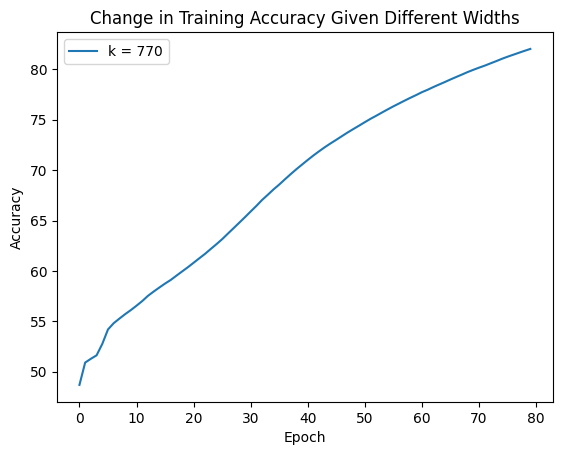

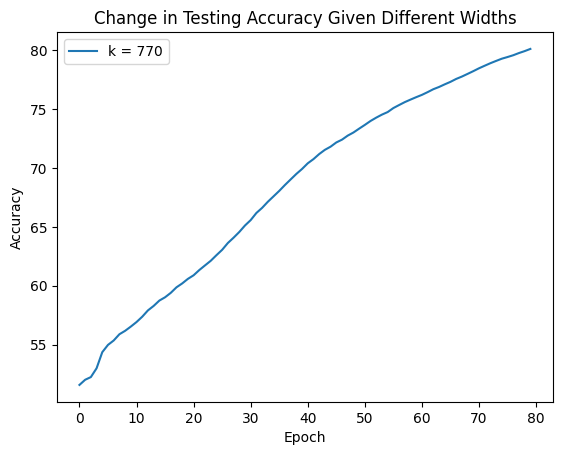

In [52]:
import matplotlib.pyplot as plt

lab = "k = {}".format(K)
plt.figure(1)
plt.plot(traccs, label=lab)
plt.title("Change in Training Accuracy Given Different Widths")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.figure(2)
plt.plot(tsaccs, label=lab)
plt.title("Change in Testing Accuracy Given Different Widths")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [55]:
#deep neural network
n_in = 768
n_out = 3
learning_rate = 0.001
P = 1.0
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, 770) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(770, 700)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization
        self.fc3 = nn.Linear(700, 600) 
        torch.nn.init.kaiming_uniform_(self.fc3.weight) #He initialization
        self.fc4 = nn.Linear(600, 500)
        torch.nn.init.kaiming_uniform_(self.fc4.weight) #He initialization
        self.fc5 = nn.Linear(500, 400) 
        torch.nn.init.kaiming_uniform_(self.fc5.weight) #He initialization
        self.fc6 = nn.Linear(400, 300)
        torch.nn.init.kaiming_uniform_(self.fc6.weight) #He initialization
        self.fc7 = nn.Linear(300, 200) 
        torch.nn.init.kaiming_uniform_(self.fc7.weight) #He initialization
        self.fc8 = nn.Linear(200, 100)
        torch.nn.init.kaiming_uniform_(self.fc8.weight) #He initialization
        self.fc9 = nn.Linear(100, 50) 
        torch.nn.init.kaiming_uniform_(self.fc9.weight) #He initialization
        self.fc10 = nn.Linear(50, n_out)
        torch.nn.init.kaiming_uniform_(self.fc10.weight) #He initialization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.sigmoid(self.fc10(x))
        return x

net = Net().to(device)
#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

C:\Users\huntm\anaconda3\envs\alt\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


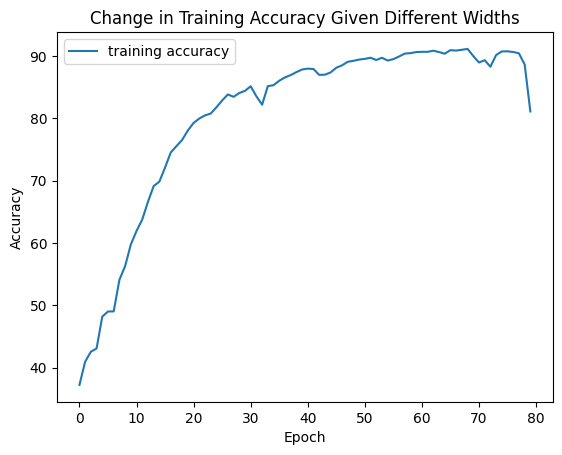

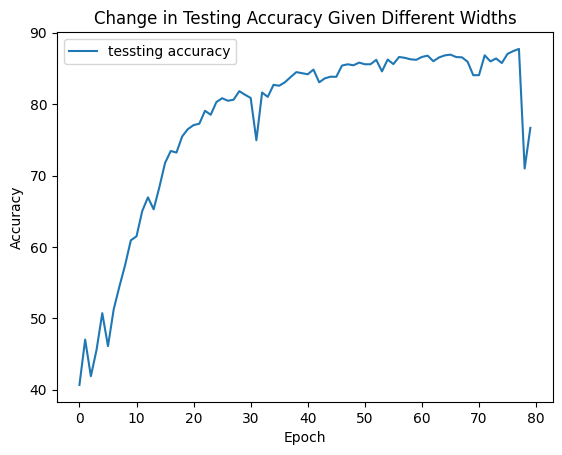

In [56]:
traccs = []
tsaccs = []
for epoch in range(epochs):
    correct = 0
    size = 0
    net.train()
    for b, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() 
        output = net(x)
        #print(output)
        #acu += (output.argmax(1) == y).float().sum().item()
        cor = (output.argmax(1) == y).float().sum().item()

        correct += cor
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        size += len(x)

    #accs.append(100 * (acu / len(y_tr)))
    traccs.append((100 * correct) / size)
    net.eval()
    correct = 0
    size = 0
    with torch.no_grad():
        for b, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            #print(output)
            #acu += (output.argmax(1) == y).float().sum().item()
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            size += len(x)

        #accs.append(100 * (acu / len(y_tr)))
        tsaccs.append((100 * correct) / size)

lab = "training accuracy"
plt.figure(1)
plt.plot(traccs, label=lab)
plt.title("Change in Training Accuracy Given Different Widths")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
lab = "tessting accuracy"
plt.figure(2)
plt.plot(tsaccs, label=lab)
plt.title("Change in Testing Accuracy Given Different Widths")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()